In [4]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения
from sklearn.datasets import fetch_openml
%matplotlib inline 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Загрузка и обработка данных

Этот датасет представляет собой практику методов парсинга веб-сайта ИКЕА в Саудовской Аравии для категории мебели. Ссылка на извлеченный веб-сайт: https://www.ikea.com/sa/en/cat/furniture-fu001/
Данные запрошены до 20.04.2020.

Задача: предсказать, превысит ли товар стоимость в SR 1000, основываясь на имеющихся данных.

In [5]:
data_raw = pd.read_csv("C:/Users/dmitr/Downloads/chrome/IKEA.csv")
data_raw.shape


(3694, 14)

In [6]:
del data_raw['Unnamed: 0']
data_raw = data_raw.dropna(subset=['width'])
data_raw = data_raw.dropna(subset=['height'])
data_raw = data_raw.dropna(subset=['depth'])

data_raw['price > 1000'] = data_raw['price']>1000

In [7]:
del data_raw['link']
del data_raw['short_description']
del data_raw['old_price']
del data_raw['designer']
num_columns   = [c for c in data_raw.columns if data_raw[c].dtype.name != 'object']
print(num_columns)
data_describe = data_raw.describe(include = [object])
number = preprocessing.LabelEncoder()
data_raw["name"] = number.fit_transform(data_raw["name"])
data_raw["category"] = number.fit_transform(data_raw["category"])
data_raw['sellable_online'] = pd.factorize(data_raw['sellable_online'])[0]
data_raw['price > 1000'] = pd.factorize(data_raw['price > 1000'])[0]
data_raw['other_colors'] = pd.factorize(data_raw['other_colors'])[0]

['item_id', 'price', 'sellable_online', 'depth', 'height', 'width', 'price > 1000']


In [8]:
data_raw

,item_id,name,category,price,sellable_online,other_colors,depth,height,width,price > 1000
3,80155205,235,0,69.0,0,0,50.0,100.0,60.0,0
4,30180504,176,0,225.0,0,1,60.0,43.0,74.0,0
5,10122647,108,0,345.0,0,1,45.0,91.0,40.0,0
6,70404875,66,0,129.0,0,1,44.0,95.0,50.0,0
8,50406465,66,0,129.0,0,1,44.0,95.0,50.0,0
...,...,...,...,...,...,...,...,...,...,...
3683,39329299,193,16,1260.0,0,0,60.0,201.0,75.0,1
3684,49157565,54,16,1245.0,0,1,55.0,216.0,164.0,1
3685,59324936,192,16,2100.0,0,0,60.0,236.0,100.0,1
3686,69330475,198,16,3985.0,0,1,66.0,236.0,150.0,1


# Разделение данных на обучающую и тестовую выборки

In [9]:
X = data_raw.drop('item_id', axis = 1) 
y = data_raw['item_id']
new_id = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.shape

(380, 9)

In [10]:
X_train.shape

(1519, 9)

# Подбор гиперпараметров 

Подберем оптимальное значение параметра регуляризации alpha. Алгоритм оптимизации - Adam, функция активации - Relu.

In [11]:
alpha_arr = np.logspace(-3, 2, 25)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in tqdm(alpha_arr):
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (20,), 
                              solver='adam', activation='relu', max_iter=1000, random_state=266)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [11:01<00:00, 26.46s/it]


Построим график зависимости ошибки на тестовой и обучающей выборках от параметра регуляризации.

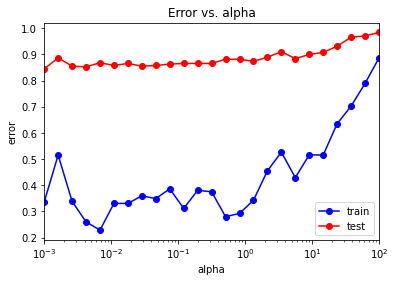

In [12]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

Для небольшого объема данных ошибки на обучающей и тестовой выборках сильно отличаются, что указывает на переобучение. Для той же модели, но с большим объемом данных ошибки сближаются, что указывает на недообучение.

Дополнительно построим график зависимости точности на тестовой и обучающей выборках от параметра регуляризации.

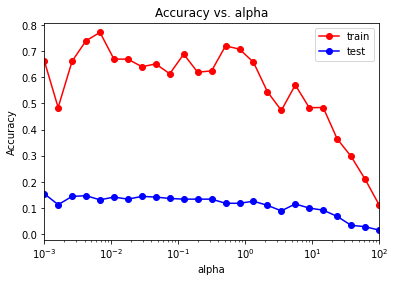

In [13]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Расчитаем минимальные ошибки на выборках.

In [14]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.228439763001975 0.8447368421052631


На тестовой выборке ошибка близка к единице. Возможно это из-за маленького количества итераций или из-за большого количества данных. К тому же данные весьма разнородные, что играет решающую роль в обучаемости нейронной сети.

Оптимальное значение параметра регуляризации:

In [15]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.001]


In [16]:
alpha_opt = alpha_opt[0]

Теперь подберём число нейронов в однослойном классификаторе.  Алгоритм оптимизации - Adam, функция активации - Relu.

In [17]:
hidden_layer_size = np.linspace(1, 100, 25)
hidden_layer_size = hidden_layer_size.astype(int)
test_err = []
train_err = []

for size in tqdm(hidden_layer_size):
    model = MLPClassifier(hidden_layer_sizes=(size), solver='adam', activation='relu', max_iter=1000,  random_state=662)
    model.fit(X_train, y_train)
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [11:45<00:00, 28.24s/it]


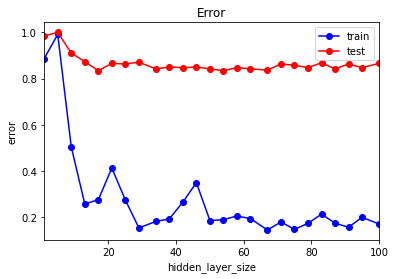

In [18]:
plt.plot(hidden_layer_size, train_err, 'b-o', label = 'train')
plt.plot(hidden_layer_size, test_err, 'r-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Error')
plt.xlabel('hidden_layer_size')
plt.ylabel('error')
plt.legend()

In [19]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.14549045424621462 0.8342105263157895


Снова большая ошибка на тестовой выборке, явное переобучение. Я уже сто раз убедилась в том, что датасет выбран не подходящий, но доведём дело до конца.

In [20]:
hl_train_size = hidden_layer_size[np.argmin(train_err)]
hl_test_size_ = hidden_layer_size[np.argmin(test_err)]
print(hl_train_size, hl_test_size_)

67 17


Получили количество нейронов = 17.

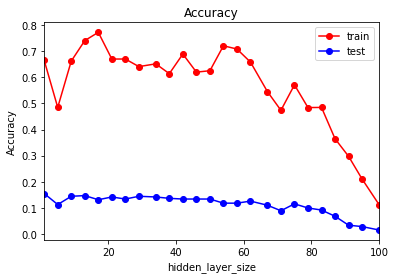

In [21]:
plt.plot(hidden_layer_size, train_acc, 'r-o', label = 'train')
plt.plot(hidden_layer_size, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Accuracy')
plt.xlabel('hidden_layer_size')
plt.ylabel('Accuracy')
plt.legend()

In [27]:
max_train_acc = np.max(train_acc)
max_test_acc = np.max(test_acc)
print(max_train_acc, max_test_acc)

0.771560236998025 0.15526315789473685


Подберём число нейронов в двухслойном классификаторе. 

In [25]:
sizes = np.linspace(1, 100, 5).astype(int)
test_err = np.zeros((5, 5))
train_err = np.zeros((5, 5))

for i, size_1 in tqdm(enumerate(sizes)):
    for j, size_2 in enumerate(sizes):
        model = MLPClassifier(hidden_layer_sizes=(size_1, size_2, ), solver='adam', activation='relu', 
                              max_iter=2000, random_state=123)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_err[i][j] = np.mean(y_train != y_train_pred)
        test_err[i][j] = np.mean(y_test != y_test_pred)

5it [14:24, 172.82s/it]


([<matplotlib.axis.YTick at 0x1faf82dea30>,
 [Text(0, 0, '1.0'),
  Text(0, 1, '11.0'),
  Text(0, 2, '21.0'),
  Text(0, 3, '31.0'),
  Text(0, 4, '41.0')])

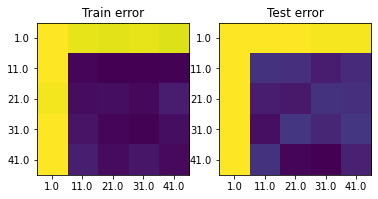

In [32]:
plt.subplot(121)
plt.title("Train error")
plt.imshow(train_err)
plt.xticks(np.arange(5), np.arange(1, 50, 50 / 5))
plt.yticks(np.arange(5), np.arange(1, 50, 50 / 5))

plt.subplot(122)
plt.title("Test error")
plt.imshow(test_err)
plt.xticks(np.arange(5), np.arange(1, 50, 50 / 5))
plt.yticks(np.arange(5), np.arange(1, 50, 50 / 5))


In [33]:
train_min_loss = np.where(train_err == np.min(train_err))
test_min_loss = np.where(test_err == np.min(test_err))
train_min_loss_sizes = np.where(train_err == np.min(train_err))
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.13759052007899933 0.8026315789473685


In [36]:
train_max_acc = np.where(train_acc == np.max(train_acc))
test_max_acc = np.where(test_acc == np.max(test_acc))
max_train_acc = np.max(train_acc)
max_test_acc = np.max(test_acc)
print(max_train_acc, max_test_acc)

0.771560236998025 0.15526315789473685


# Выводы
В ходе выполнения всех заданий, выяснилось, что для данных с сайта Икеи поставленная задача некорректна для решения нейронной сетью. Чтобы сеть обучалась, данные нужно более тщательно обработать, избавиться от разнородности признаков и, возможно, уменьшить количество самих данных. Также может помочь выравнивание классов. 
А пока что наблюдается и переобучение, и недообучение, и большие ошибки, и маленькие точности на тестовых выборках..